In [1]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

data = load_data("../stats/fpm_2_open_solver_1.json")

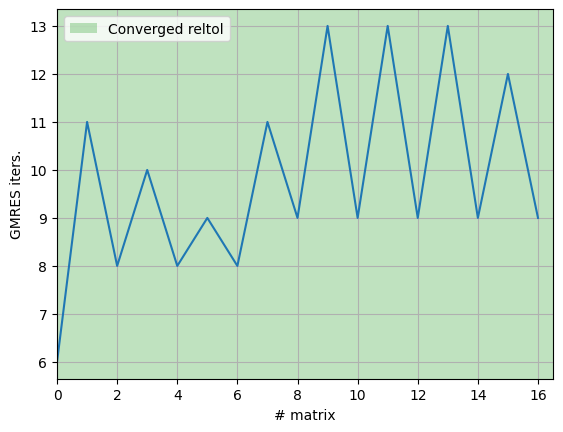

In [2]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [3]:
mat_idx = 14
# mat_idx = 8
get_gmres_iterations(data)[mat_idx]

9

In [4]:
sticking, sliding, open = get_num_sticking_sliding_open(data)
print(sticking[mat_idx], sliding[mat_idx], open[mat_idx])

8 0 160


In [5]:
from plot_utils import *

mat, rhs = load_matrix_rhs(data, mat_idx)

In [6]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_2 import make_model
from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)
mat = mat[reorder]

# model.assemble_linear_system()
# mat, rhs = model.linear_system
model.linear_system = mat, rhs
perm_mat, prec_orig = model._prepare_solver()

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


Solve  took: 0.54


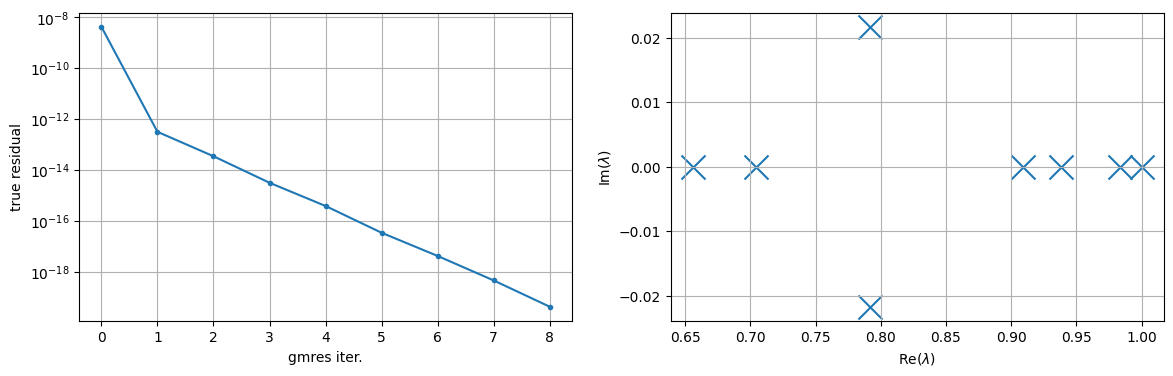

In [7]:
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

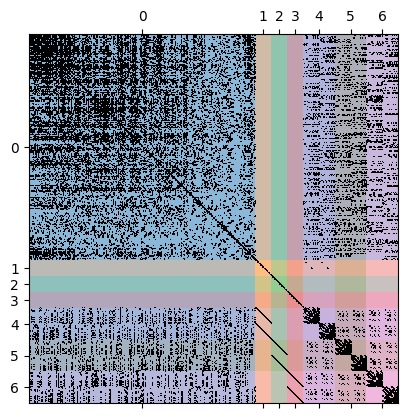

In [8]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)

J = BlockMatrixStorage(
    mat=mat,
    row_idx=corrected_eq_dofs,
    col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    group_col_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']
)

J[[1, 4, 5]].color_spy(False)

# J[:].color_spy()
# J[:].plot_max()
# J[:].matshow()

/home/porepy/simulations/plot_utils.py:102: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


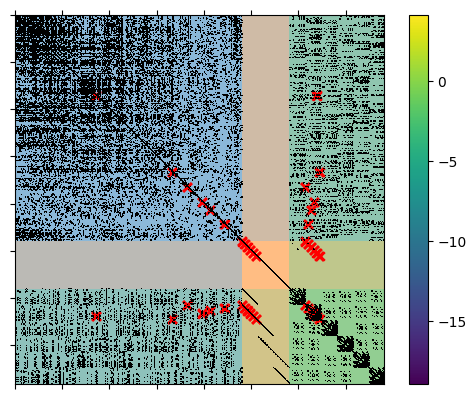

In [9]:
# %matplotlib tk
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from preconditioner_mech import build_mechanics_stabilization
from porepy.numerics.linalg.matrix_operations import sparse_kronecker_product

fractures = model.mdg.subdomains(dim=model.nd - 1)

tmp = J[[1, 4,5]]
J_51 = J[5, 1]
# tmp[[4, 5]] = build_mechanics_stabilization(model, J, build_schur=False)

tmp.color_spy(groups=True, show=False, aspect='equal', marker=',')
tmp.matshow(log=True, show=False)


for frac_idx, frac in enumerate(fractures):
    if frac_idx != 0:
        continue
    intfs = model.mdg.subdomain_to_interfaces(sd=frac)
    for intf in intfs:
        if intf.dim < frac.dim:
            continue

        matrix = model.mdg.interface_to_subdomain_pair(intf=intf)[0]
        assert matrix.dim == model.nd

        secondary_to_mortar = intf.secondary_to_mortar_avg(nd=model.nd).tocsc()
        mortar_to_primary = intf.mortar_to_primary_avg(nd=model.nd).tocsc()
        faces_to_cells = sparse_kronecker_product(
            matrix.cell_faces.T, nd=model.nd
        ).tocsc()
        sign_to_mortar_side = intf.sign_of_mortar_sides(nd=model.nd).diagonal()
        secondary_to_mortar.eliminate_zeros()
        mortar_to_primary.eliminate_zeros()
        faces_to_cells.eliminate_zeros()

        intf_to_mat_cells = faces_to_cells @ mortar_to_primary

        for frac_cell_id in range(frac.num_cells):
            # if frac_cell_id != 8:
            if frac_cell_id % 10 != 0:
                continue

            frac_cells = frac_cell_id * model.nd + np.arange(model.nd)
            intf_cells = secondary_to_mortar[:, frac_cells].indices

            signs = sign_to_mortar_side[intf_cells]
            plus = signs == 1
            intf_cells = intf_cells[plus]

            mat_cells = intf_to_mat_cells[:, intf_cells].indices

            row_idx, col_idx = tmp.get_global_indices([intf_cells, intf_cells], group=(5, 5), subgroup=(frac_idx, frac_idx))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([frac_cells, intf_cells], group=(4, 5), subgroup=(frac_idx, frac_idx))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([frac_cells, frac_cells], group=(4, 4), subgroup=(frac_idx, frac_idx))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([intf_cells, frac_cells], group=(5, 4), subgroup=(frac_idx, frac_idx))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([intf_cells, mat_cells], group=(5, 1), subgroup=(frac_idx, 0))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([mat_cells, intf_cells], group=(1, 5), subgroup=(0, frac_idx))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([mat_cells, mat_cells], group=(1, 1), subgroup=(0, 0))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = J_51.get_global_indices([intf_cells, mat_cells], group=(5, 1), subgroup=(frac_idx, 0))
            x = J_51.mat[row_idx]
            # assert x[:, col_idx].nnz == 18

plt.show()

In [10]:
def make_active_row_col():
    fractures = model.mdg.subdomains(dim=model.nd - 1)

    result_cols = []
    result_rows = []

    for frac_idx, frac in enumerate(fractures):
        intfs = model.mdg.subdomain_to_interfaces(sd=frac)
        for intf in intfs:
            if intf.dim < frac.dim:
                continue

            matrix = model.mdg.interface_to_subdomain_pair(intf=intf)[0]
            assert matrix.dim == model.nd

            secondary_to_mortar = intf.secondary_to_mortar_avg(nd=model.nd).tocsc()
            mortar_to_primary = intf.mortar_to_primary_avg(nd=model.nd).tocsc()
            faces_to_cells = sparse_kronecker_product(
                matrix.cell_faces.T, nd=model.nd
            ).tocsc()
            sign_to_mortar_side = intf.sign_of_mortar_sides(nd=model.nd).diagonal()
            secondary_to_mortar.eliminate_zeros()
            mortar_to_primary.eliminate_zeros()
            faces_to_cells.eliminate_zeros()

            intf_to_mat_cells = faces_to_cells @ mortar_to_primary

            for frac_cell_id in range(frac.num_cells):
                frac_cells = frac_cell_id * model.nd + np.arange(model.nd)
                intf_cells = secondary_to_mortar[:, frac_cells].indices

                signs = sign_to_mortar_side[intf_cells]
                for sign_val in (1, -1):
                    plus = signs == sign_val
                    intf_cells_side = intf_cells[plus]

                    mat_cells_side = intf_to_mat_cells[:, intf_cells_side].indices

                    row_idx, col_idx = J_51.get_global_indices(
                        [intf_cells_side, mat_cells_side],
                        group=(5, 1),
                        subgroup=(frac_idx, 0),
                    )

                    result_rows.append(row_idx)
                    result_cols.append(col_idx)

    result_rows = np.array(result_rows)
    result_cols = np.array(result_cols)

    return result_rows, result_cols

def lump_rect(mat, nd: int, lump_axis=1):
    result = np.zeros((mat.shape[0], nd))
    ind_start_i = np.arange(0, mat.shape[0], nd)
    ind_start_j = np.arange(0, mat.shape[0], nd)

    for i in range(nd):
        for j in range(nd):
            indices_i = ind_start_i + i
            indices_j = ind_start_j + j
            I, J = np.meshgrid(
                indices_i, indices_j, copy=False, sparse=True, indexing="ij"
            )
            submat = mat[I, J]
            lump = np.array(submat.sum(axis=lump_axis)).ravel()
            result[indices_i, j] = lump
    return result


def make_lumped_mat(mat, lump_axis=1):
    result_rows, result_cols = make_active_row_col()
    data = lump_rect(mat, nd=model.nd, lump_axis=lump_axis)
    lumped_mat = scipy.sparse.lil_matrix(mat.shape)
    for i in range(len(result_rows)):
        lumped_rows = result_rows[i: i + 1].ravel()
        lumped_cols = result_cols[i: i + 1].ravel()
        I, J = np.meshgrid(lumped_rows, lumped_cols, indexing='ij', sparse=True, copy=False)
        lumped_mat[I, J] = data[i * model.nd: (i + 1) * model.nd]
    return lumped_mat.tocsr()


In [11]:
J_51_lumped = make_lumped_mat(J[5,1].mat, lump_axis=1)
J_15_lumped = make_lumped_mat(J[1,5].mat.T, lump_axis=1).T
tmp = J[[1,4,5]].copy()

tmp[5,1] = J_51_lumped
tmp[1,5] = J_15_lumped

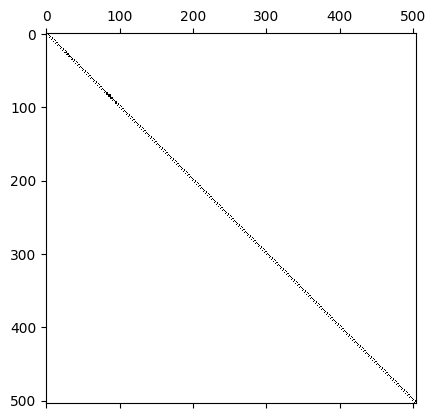

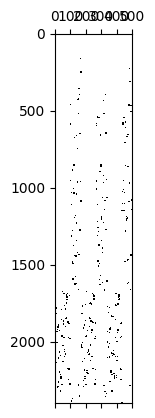

Solve  took: 1.41


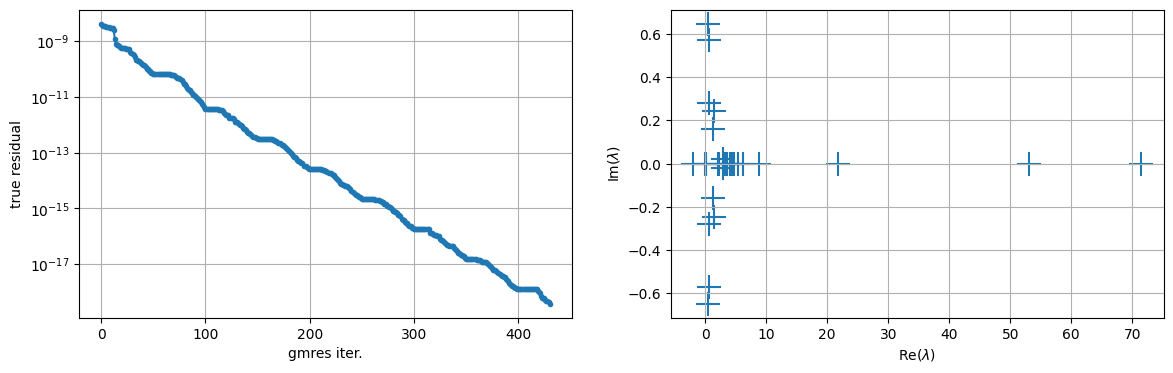

In [12]:
schema_1 = SolveSchema(
    groups=[1],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
)

def foo(mat10, mat01):
    mat10[1, 5] = J_15_lumped
    mat01[5, 1] = J_51_lumped
    return mat10, mat01

def foo1(mat10, mat01):
    # mat10[1, 5] = J_15_lumped
    # mat01[5, 1] = J_51_lumped
    return mat10, mat01

schema_5_4_1 = SolveSchema(
    groups=[5],
    transform_nondiagonal_blocks=foo,
    invertor=lambda bmat: inv_block_diag(lump_nd(bmat.mat, nd=model.nd), nd=model.nd),
    complement=SolveSchema(
        groups=[4],
        solve="use_invertor",
        # transform_nondiagonal_blocks=foo1,
        invertor=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
        complement=schema_1,
    ),
)

mat_permuted, prec = make_solver(schema=schema_5_4_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Solve  took: 0.67


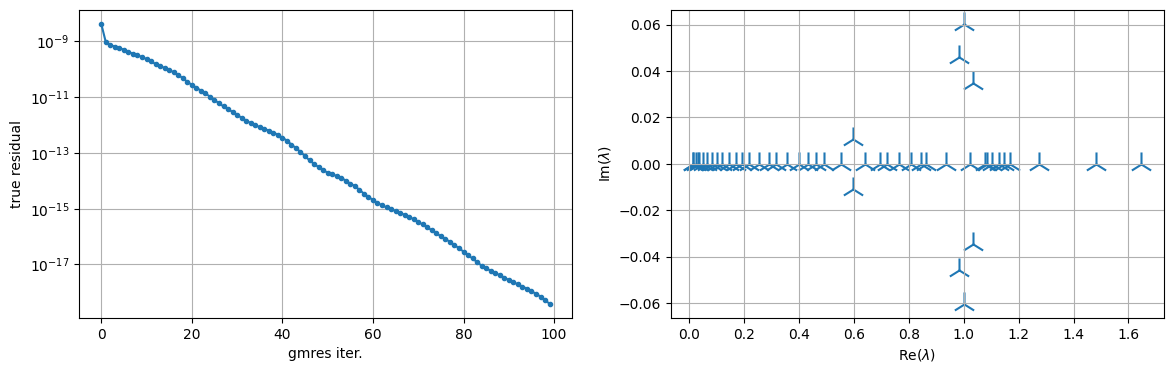

In [39]:
from preconditioner_mech import build_mechanics_stabilization

J_51_lumped = make_lumped_mat(J[5,1].mat, lump_axis=1)
J_15_lumped = make_lumped_mat(J[1,5].mat.T, lump_axis=0).T
tmp = J[[1,4,5]].copy()

tmp[5,1] = J_51_lumped
# tmp[1,5] = J_15_lumped

schema_45_1 = SolveSchema(
    groups=[4, 5],
    solve='direct',
    # solve=lambda bmat: build_mechanics_stabilization(model, bmat, lump=True, build_schur=False),
    # invertor=lambda x: scipy.sparse.eye(x.shape[0]),

    # only_complement=True,

    invertor=lambda: build_mechanics_stabilization(model, tmp, lump=True),
    invertor_type='physical',
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))